# 3.2 Deep Feedforward Neural Network Model (w/o GAN data)

## 1. Load In

In [1]:
import nibabel as nib
import numpy as np
import glob
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

np.random.seed(42) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(42)

import visualkeras

In [3]:
df = pd.read_csv('/project/ds6050-soa2wg/team_lambda_II/ASD_DSM_CasesvsControls.csv', sep = ',')

In [4]:
# obtain paths for all images
images_paths_f_case = list(df.query("SEX_ == 'Female' & DX_Control == 'Autism'")['PATH'])
images_paths_f_control = list(df.query("SEX_ == 'Female' & DX_Control == 'Control'")['PATH'])
images_paths_m_case = list(df.query("SEX_ == 'Male' & DX_Control == 'Autism'")['PATH'])
images_paths_m_control = list(df.query("SEX_ == 'Male' & DX_Control == 'Control'")['PATH'])

total_cases = len(images_paths_f_case) + len(images_paths_m_case)
total_controls = len(images_paths_f_control ) + len(images_paths_m_control)
# print out number of participants per category
print('There are {} female cases'.format(str(len(images_paths_f_case))))
print('---------------------------------------')
print('There are {} female controls'.format(str(len(images_paths_f_control))))
print('---------------------------------------')
print('There are {} male cases'.format(str(len(images_paths_m_case))))
print('---------------------------------------')
print('There are {} male controls'.format(str(len(images_paths_m_control))))
print('---------------------------------------')
print(f'There are {total_cases} total cases and {total_controls} total controls! {total_controls + total_cases} participants in total')
# make one giant list
images_paths = images_paths_f_case  + images_paths_f_control + images_paths_m_case + images_paths_m_control

num_im = len(images_paths)
image_array = []

There are 22 female cases
---------------------------------------
There are 61 female controls
---------------------------------------
There are 124 male cases
---------------------------------------
There are 184 male controls
---------------------------------------
There are 146 total cases and 245 total controls! 391 participants in total


In [5]:
final_list = [] # create image array from paths
for path in images_paths:
    try: 
        img = nib.load(path)
        image_data = img.get_fdata()
        image_array.append(image_data)
        final_list.append(path)
    except:
        continue
    
image_array = np.asarray(image_array).astype('float32')

In [6]:
image_array.shape

(391, 61, 73, 61)

In [7]:
pheno = df[['FILE_ID', 'DX_GROUP']]
pheno_array = np.array(pheno['DX_GROUP'])
pheno_array = np.where(pheno_array == 2, 0, pheno_array)
# distribution
df['DX_GROUP'].value_counts()

2    245
1    146
Name: DX_GROUP, dtype: int64

In [8]:
#training and holdout split
x_train, x_val, y_train, y_val = train_test_split(image_array, pheno_array, test_size = 0.15, random_state = 654)

#training and testing split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.25, random_state = 654)

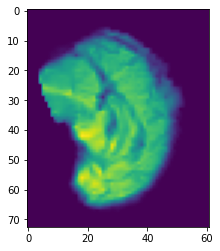

In [34]:
# preview of image
plt.imshow(x_train[5][30])

In [10]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 16
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
#     .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_test))
#    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

2022-05-03 19:00:33.137867: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-03 19:00:34.877190: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38397 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:87:00.0, compute capability: 8.0


## 2. Model

### 2.1 Highest performing DFNN architecture from Mellema 2022

In [11]:
def Dense_model(width=61, height=73, depth=61):
    """Build a Highest performing Dense FNN neural network model from Mellema 2022."""

    inputs = keras.Input((width, height, depth, 1))
    
    x = layers.Dense(6,kernel_regularizer=tf.keras.regularizers.l2(0.0001))(inputs)
    x = layers.Dense(units=64, activation="relu")(x)
    x = layers.Dropout(0.13)(x)
    x = layers.Dense(units=64, activation="relu")(x)
    x = layers.Flatten()(x)
    

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="DFNN")
    return model


# Build model.
model = Dense_model(width=61, height=73, depth=61)
model.summary()

Model: "DFNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 61, 73, 61, 1)]   0         
                                                                 
 dense (Dense)               (None, 61, 73, 61, 6)     12        
                                                                 
 dense_1 (Dense)             (None, 61, 73, 61, 64)    448       
                                                                 
 dropout (Dropout)           (None, 61, 73, 61, 64)    0         
                                                                 
 dense_2 (Dense)             (None, 61, 73, 61, 64)    4160      
                                                                 
 flatten (Flatten)           (None, 17384512)          0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1738451

In [30]:
# Compile model.
initial_learning_rate = 0.0001

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.95, staircase=True
)

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()],
)

# Define callbacks.
#checkpoint_cb = keras.callbacks.ModelCheckpoint(
 #   "3d_image_classification_Cxa_DFNN_nogan.h5", save_best_only=True
#)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=20)

# Train the model, doing validation at the end of each epoch
epochs = 50
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    callbacks=early_stopping_cb
)

Epoch 1/50
8/8 [==============================] - 2s 179ms/step - loss: 53245.9102 - binary_accuracy: 0.5663 - auc_9: 0.5260 - val_loss: 35444.1172 - val_binary_accuracy: 0.3614 - val_auc_9: 0.5000
Epoch 2/50
8/8 [==============================] - 1s 146ms/step - loss: 28156.6152 - binary_accuracy: 0.5221 - auc_9: 0.4863 - val_loss: 34380.9688 - val_binary_accuracy: 0.3614 - val_auc_9: 0.5000
Epoch 3/50
8/8 [==============================] - 1s 148ms/step - loss: 15616.1309 - binary_accuracy: 0.6265 - auc_9: 0.6016 - val_loss: 10687.4883 - val_binary_accuracy: 0.6506 - val_auc_9: 0.6830
Epoch 4/50
8/8 [==============================] - 1s 152ms/step - loss: 14456.1152 - binary_accuracy: 0.6265 - auc_9: 0.6079 - val_loss: 8416.5283 - val_binary_accuracy: 0.7108 - val_auc_9: 0.7157
Epoch 5/50
8/8 [==============================] - 1s 146ms/step - loss: 11927.9326 - binary_accuracy: 0.6747 - auc_9: 0.6550 - val_loss: 6650.3667 - val_binary_accuracy: 0.6386 - val_auc_9: 0.6736
Epoch 6/50
8

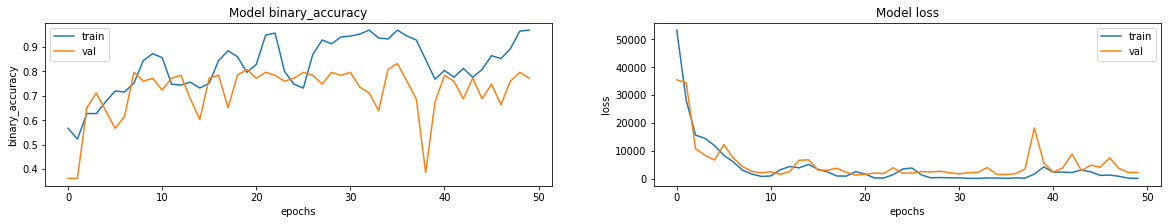

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["binary_accuracy", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [32]:
# Load best weights.
#model.load_weights("3d_image_classification_Cxa.h5")
prediction = model.predict(np.expand_dims(x_test[0], axis=0))[0]
print(prediction)
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )
print(y_test[0])

[1.]
This model is 0.00 percent confident that CT scan is normal
This model is 100.00 percent confident that CT scan is abnormal
1


In [33]:
#proportion of training data that's positive
sum(y_train) / len(y_train)

#proportion of holdout data that's positive
(sum(y_val) / len(y_val))

#evaluate on the holdout data
model.evaluate(x_val, y_val)

2/2 [==============================] - 0s 39ms/step - loss: 3604.9121 - binary_accuracy: 0.7119 - auc_9: 0.7334


[3604.912109375, 0.7118644118309021, 0.7334151864051819]

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

preds = model.predict(x_val)

preds = np.where(preds > .5, 1,0)



print(classification_report(y_val, preds))
cm = confusion_matrix(y_val, preds)

              precision    recall  f1-score   support

           0       0.86      0.65      0.74        37
           1       0.58      0.82      0.68        22

    accuracy                           0.71        59
   macro avg       0.72      0.73      0.71        59
weighted avg       0.75      0.71      0.72        59



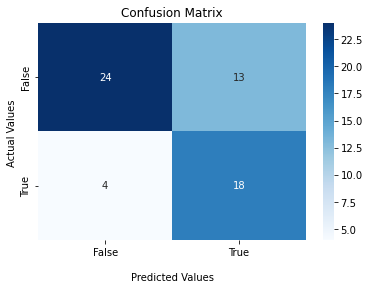

In [35]:
import seaborn as sns

ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

### 2.2 Build a Highest performing Dense FNN neural network model from Mellema 2022 with modifications ** Best Performing without GAN Data**

In [11]:
def Dense_model(width=61, height=73, depth=61):
    """Build a Highest performing Dense FNN neural network model from Mellema 2022 with modifications."""

    inputs = keras.Input((width, height, depth, 1))  
     
    x = layers.Dense(6,kernel_regularizer=tf.keras.regularizers.l2(0.0001))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(units=128, activation="relu")(x)
    x = layers.Dropout(0.13)(x)
    x = layers.Dense(units=64, activation="relu")(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="DFNN")
    return model


# Build model.
model = Dense_model(width=61, height=73, depth=61)
model.summary()

Model: "DFNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 61, 73, 61, 1)]   0         
                                                                 
 dense (Dense)               (None, 61, 73, 61, 6)     12        
                                                                 
 batch_normalization (BatchN  (None, 61, 73, 61, 6)    24        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 61, 73, 61, 128)   896       
                                                                 
 dropout (Dropout)           (None, 61, 73, 61, 128)   0         
                                                                 
 dense_2 (Dense)             (None, 61, 73, 61, 64)    8256      
                                                              

In [12]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)

# Compile model.
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()],
)

# Define callbacks.
#checkpoint_cb = keras.callbacks.ModelCheckpoint(
 #   "3d_image_classification_Cxa_adamDFNN.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 50
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    callbacks=early_stopping_cb,
)

Epoch 1/50


2022-05-03 19:00:46.268780: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-05-03 19:00:48.210347: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


16/16 [==============================] - 8s 138ms/step - loss: 20.7618 - binary_accuracy: 0.4378 - auc: 0.4142 - val_loss: 27.3884 - val_binary_accuracy: 0.6386 - val_auc: 0.5000
Epoch 2/50
16/16 [==============================] - 2s 120ms/step - loss: 8.4328 - binary_accuracy: 0.5502 - auc: 0.5365 - val_loss: 9.7288 - val_binary_accuracy: 0.4819 - val_auc: 0.6160
Epoch 3/50
16/16 [==============================] - 2s 120ms/step - loss: 4.3228 - binary_accuracy: 0.6546 - auc: 0.6373 - val_loss: 3.4864 - val_binary_accuracy: 0.6386 - val_auc: 0.7947
Epoch 4/50
16/16 [==============================] - 2s 120ms/step - loss: 1.2048 - binary_accuracy: 0.7671 - auc: 0.8036 - val_loss: 4.7699 - val_binary_accuracy: 0.5060 - val_auc: 0.6811
Epoch 5/50
16/16 [==============================] - 2s 120ms/step - loss: 1.3610 - binary_accuracy: 0.7229 - auc: 0.7646 - val_loss: 1.0576 - val_binary_accuracy: 0.7590 - val_auc: 0.8390
Epoch 6/50
16/16 [==============================] - 2s 120ms/step - l

In [22]:
# Save the weights
#model.save_weights('DFNN_mod2.h5')

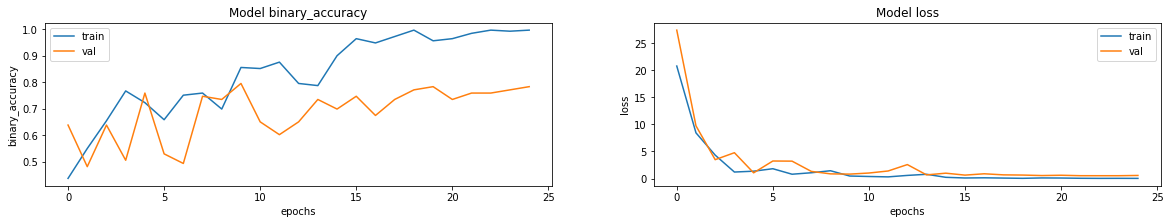

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["binary_accuracy", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [14]:
prediction = model.predict(np.expand_dims(x_test[0], axis=0))[0]
print(prediction)
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )
print(y_test[0])

[0.7499207]
This model is 25.01 percent confident that CT scan is normal
This model is 74.99 percent confident that CT scan is abnormal
1


In [15]:
#proportion of training data that's positive
sum(y_train) / len(y_train)

#proportion of holdout data that's positive
(sum(y_val) / len(y_val))

#evaluate on the holdout data
model.evaluate(x_val, y_val)

2/2 [==============================] - 0s 56ms/step - loss: 0.7538 - binary_accuracy: 0.8305 - auc: 0.8213


[0.7538281679153442, 0.8305084705352783, 0.8212530612945557]

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

preds = model.predict(x_val)

preds = np.where(preds > .5, 1,0)



print(classification_report(y_val, preds))
cm = confusion_matrix(y_val, preds)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87        37
           1       0.80      0.73      0.76        22

    accuracy                           0.83        59
   macro avg       0.82      0.81      0.82        59
weighted avg       0.83      0.83      0.83        59



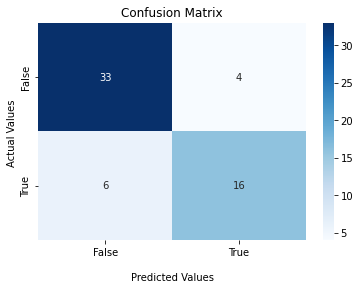

In [18]:
ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

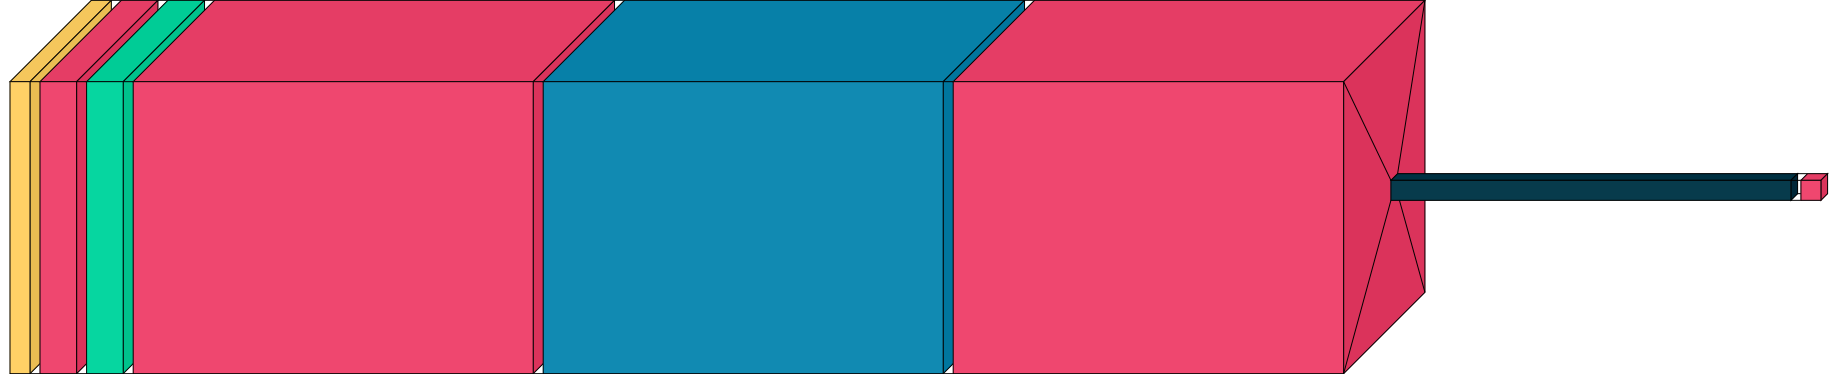

In [20]:
visualkeras.layered_view(model)

In [20]:
from PIL import ImageFont

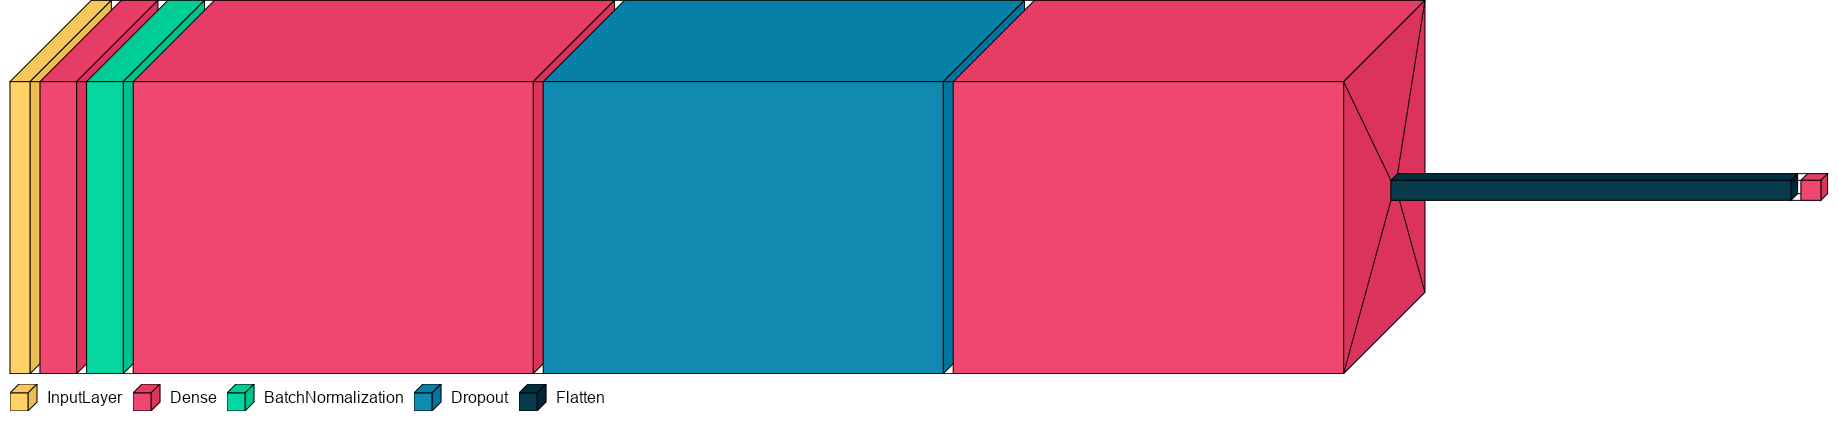

In [21]:
font = ImageFont.truetype("Arial.ttf", 16)
visualkeras.layered_view(model, legend=True,font = font, to_file='DFNN2arch.png')  # font is optional!

### 2.3 Complex Highest performing Dense FNN neural network model from Mellema 2022 with modifications

In [25]:
def Dense_model(width=61, height=73, depth=61):
    """Build a complex Highest performing Dense FNN neural network model from Mellema 2022."""

    inputs = keras.Input((width, height, depth, 1))
    
    x = layers.Dense(units=128, activation="relu", kernel_regularizer = keras.regularizers.L2(0.00011))(inputs)
    
    x = layers.BatchNormalization()(x)
    
    x = layers.Dropout(0.18)(x)
    x = layers.Dense(units=128, activation="relu")(x)
    x = layers.Dropout(0.18)(x)
    x = layers.Dense(units=64, activation="relu")(x)
    x = layers.Dropout(0.18)(x)
    x = layers.Dense(units=42, activation="relu")(x)
    x = layers.Flatten()(x)
    
    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="DFNN_complex")
    return model


# Build model.
model = Dense_model(width=61, height=73, depth=61)
model.summary()

Model: "DFNN_complex"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 61, 73, 61, 1)]   0         
                                                                 
 dense_28 (Dense)            (None, 61, 73, 61, 128)   256       
                                                                 
 batch_normalization_7 (Batc  (None, 61, 73, 61, 128)  512       
 hNormalization)                                                 
                                                                 
 dropout_14 (Dropout)        (None, 61, 73, 61, 128)   0         
                                                                 
 dense_29 (Dense)            (None, 61, 73, 61, 128)   16512     
                                                                 
 dropout_15 (Dropout)        (None, 61, 73, 61, 128)   0         
                                                      

In [26]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.96, staircase=True)

# Compile model.
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()],
)

# Define callbacks.
#checkpoint_cb = keras.callbacks.ModelCheckpoint(
 #   "3d_image_classification_Cxa_adamDFNN.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=10)

# Train the model, doing validation at the end of each epoch
epochs = 50
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    callbacks=early_stopping_cb,
)

Epoch 1/50
16/16 [==============================] - 5s 241ms/step - loss: 34.2636 - binary_accuracy: 0.5382 - auc_6: 0.5174 - val_loss: 61.9870 - val_binary_accuracy: 0.3614 - val_auc_6: 0.5000
Epoch 2/50
16/16 [==============================] - 4s 225ms/step - loss: 16.8907 - binary_accuracy: 0.5944 - auc_6: 0.5786 - val_loss: 4.2134 - val_binary_accuracy: 0.7108 - val_auc_6: 0.6940
Epoch 3/50
16/16 [==============================] - 4s 224ms/step - loss: 5.5587 - binary_accuracy: 0.6546 - auc_6: 0.6276 - val_loss: 4.6496 - val_binary_accuracy: 0.5422 - val_auc_6: 0.6903
Epoch 4/50
16/16 [==============================] - 4s 225ms/step - loss: 1.7768 - binary_accuracy: 0.7309 - auc_6: 0.7700 - val_loss: 2.2002 - val_binary_accuracy: 0.6265 - val_auc_6: 0.7956
Epoch 5/50
16/16 [==============================] - 4s 225ms/step - loss: 1.1870 - binary_accuracy: 0.7671 - auc_6: 0.8034 - val_loss: 1.0836 - val_binary_accuracy: 0.7229 - val_auc_6: 0.8195
Epoch 6/50
16/16 [===================

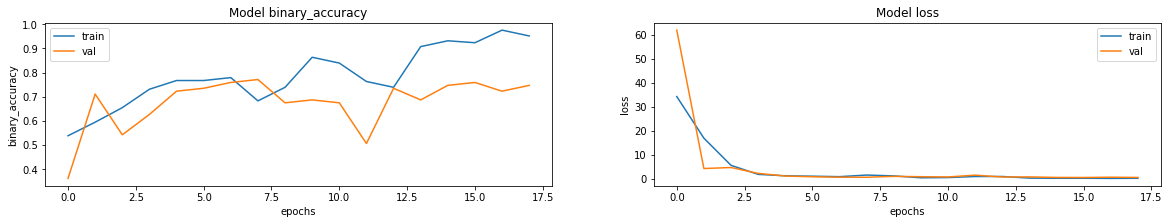

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["binary_accuracy", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [28]:
prediction = model.predict(np.expand_dims(x_test[0], axis=0))[0]
print(prediction)
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )
print(y_test[0])

[0.9050937]
This model is 9.49 percent confident that CT scan is normal
This model is 90.51 percent confident that CT scan is abnormal
1


In [29]:
#proportion of training data that's positive
sum(y_train) / len(y_train)

#proportion of holdout data that's positive
(sum(y_val) / len(y_val))

#evaluate on the holdout data
model.evaluate(x_val, y_val)

2/2 [==============================] - 0s 99ms/step - loss: 0.5346 - binary_accuracy: 0.8305 - auc_6: 0.8163


[0.5345604419708252, 0.8305084705352783, 0.8163390755653381]

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

preds = model.predict(x_val)

preds = np.where(preds > .5, 1,0)



print(classification_report(y_val, preds))
cm = confusion_matrix(y_val, preds)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87        37
           1       0.80      0.73      0.76        22

    accuracy                           0.83        59
   macro avg       0.82      0.81      0.82        59
weighted avg       0.83      0.83      0.83        59



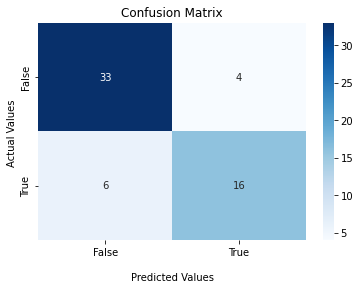

In [33]:
ax = sns.heatmap(cm, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()